# Data Preprocessing of Presidential Debate 2024 (Trump vs Harris)

In [65]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [66]:
import re
# load the abcnews_transcript file from the data folder
with open('../data/abcnews_transcript.txt', 'r') as file:
    data = file.read()


trumps_responses = []
kamalas_responses = []

trump_identifier = "FORMER PRESIDENT DONALD TRUMP: "
kamala_identifier = "VICE PRESIDENT KAMALA HARRIS: "

for line in data.split('\n'):
    if line.startswith(trump_identifier):
        trumps_responses.append(line[len(trump_identifier):])
    elif line.startswith(kamala_identifier):
        kamalas_responses.append(line[len(kamala_identifier):])

# load cleaned responses from the data folder for kamala kamala_responses_cleaned.txt
with open('../data/kamala_responses_cleaned.txt', 'r') as file:
    CLN_kamala_responses = file.read()

# load cleaned responses from the data folder for trump_responses_cleaned.txt
with open('../data/trump_responses_cleaned.txt', 'r') as file:
    CLN_trump_responses = file.read()



In [67]:
# Download and use the mlburnham/Political_DEBATE_base_v1.0 model from the huggingface model hub
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

gpu_id = 1

with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("mlburnham/Political_DEBATE_base_v1.0")
    model = AutoModelForSequenceClassification.from_pretrained("mlburnham/Political_DEBATE_base_v1.0").to(torch.device("cuda:"+str(gpu_id)))

In [150]:
# Hypotheses
hypothesis_republican = "This text expresses Republican beliefs."
hypothesis_democrat = "This text expresses Democrat beliefs."

# Function to classify each sentence
def print_political_affiliation(sentences):
    for sentence in sentences:
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_republican = tokenizer(sentence, hypothesis_republican, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_democrat = tokenizer(sentence, hypothesis_democrat, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_republican = model(**inputs_republican).logits
            logits_democrat = model(**inputs_democrat).logits

        # Compare the scores
        republican_score = torch.softmax(logits_republican, dim=1)[0][1].item()  # Entailment score for Republican
        democrat_score = torch.softmax(logits_democrat, dim=1)[0][1].item()      # Entailment score for Democrat

        # Value closer to 0 means the hypothesis is more likely
        # Value closert to 1 means the hypothesis is less likely
        # If both scores are close to 1 then the sentence is neutral
        print(f"Sentence: {sentence}")
        if republican_score < 0.5:
            print(f"--> Republican belief likely ({round(republican_score,3)}).")
        if democrat_score < 0.5:
            print(f"--> Democrat belief likely ({round(democrat_score,3)}).")
        if republican_score > 0.5 and democrat_score > 0.5:
            print("--> Neutral statement.")


In [151]:
# the following sentences are examples of political beliefs 
# the first one is a republican belief, the second one is a democrat belief and the third one is a neutral belief
test_sentences = ["I believe in lower taxes and less government intervention.", 
                    "I believe in free healthcare and education for all.", 
                    "I believe in the right to bear arms and freedom of speech.",
                    "I think Biden did not do a great job. He is a great democrat."]

# Run the classification
print_political_affiliation(test_sentences)  

Sentence: I believe in lower taxes and less government intervention.
--> Democrat belief likely (0.018).
Sentence: I believe in free healthcare and education for all.
--> Neutral statement.
Sentence: I believe in the right to bear arms and freedom of speech.
--> Neutral statement.
Sentence: I think Biden did not do a great job. He is a great democrat.
--> Republican belief likely (0.001).
--> Democrat belief likely (0.001).


In [70]:
from tqdm import tqdm
# Hypotheses
hypothesis_republican = "This text expresses Republican beliefs."
hypothesis_democrat = "This text expresses Democrat beliefs."

# Function to classify each sentence
def classify_political_affiliation(sentences):
    sentence_affiliations = {}
    for sentence in tqdm(sentences):
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_republican = tokenizer(sentence, hypothesis_republican, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_democrat = tokenizer(sentence, hypothesis_democrat, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_republican = model(**inputs_republican).logits
            logits_democrat = model(**inputs_democrat).logits

        # Compare the scores
        republican_score = torch.softmax(logits_republican, dim=1)[0][1].item()  # Entailment score for Republican
        democrat_score = torch.softmax(logits_democrat, dim=1)[0][1].item()      # Entailment score for Democrat

        # Enter sentence as key and scores as values
        sentence_affiliations[sentence] = []
        sentence_affiliations[sentence].append(republican_score)
        sentence_affiliations[sentence].append(democrat_score)

    return sentence_affiliations



In [71]:
trumps_affiliated_sentences = classify_political_affiliation(trumps_responses)  

100%|██████████| 74/74 [00:02<00:00, 31.32it/s]


In [72]:
harris_affiliated_sentences = classify_political_affiliation(kamalas_responses)

100%|██████████| 34/34 [00:01<00:00, 30.53it/s]


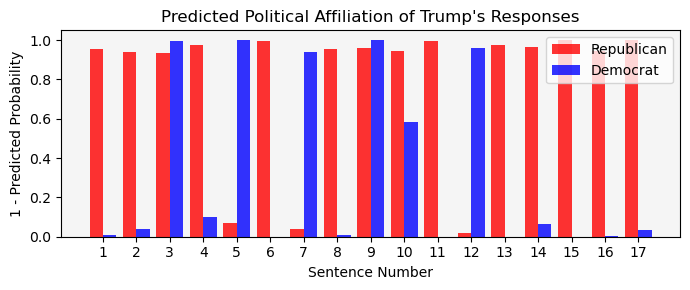

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in trumps_affiliated_sentences.items() if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 3))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
ax.set_title('Predicted Political Affiliation of Trump\'s Responses')
ax.set_xlabel('Sentence Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(np.arange(1, N + 1))
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()


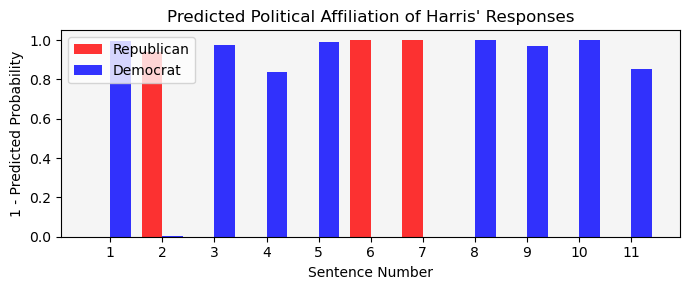

In [74]:
# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in harris_affiliated_sentences.items() if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 3))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
ax.set_title('Predicted Political Affiliation of Harris\' Responses')
ax.set_xlabel('Sentence Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(np.arange(1, N + 1))
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()

In [75]:
# Print sentences in which Harris' responses are classified as Republican
# and Trump's responses are classified as Democrat

for sentence, scores in harris_affiliated_sentences.items():
    if scores[0] < 0.5:
        print(f"Kamala Harris: {sentence}")
        print(f"Scores: {scores}")
        print("Classified as Harris saying something Republican\n")

print("\n------------------------------\n")
for sentence, scores in trumps_affiliated_sentences.items():
    if scores[1] < 0.5:
        print(f"Donald Trump: {sentence}")
        print(f"Scores: {scores}")
        print("Classified as Trump saying something Democrat\n")


Kamala Harris: So, I was raised as a middle-class kid. And I am actually the only person on this stage who has a plan that is about lifting up the middle class and working people of America. I believe in the ambition, the aspirations, the dreams of the American people. And that is why I imagine and have actually a plan to build what I call an opportunity economy. Because here's the thing. We know that we have a shortage of homes and housing, and the cost of housing is too expensive for far too many people. We know that young families need support to raise their children. And I intend on extending a tax cut for those families of $6,000, which is the largest child tax credit that we have given in a long time. So that those young families can afford to buy a crib, buy a car seat, buy clothes for their children. My passion, one of them, is small businesses. I was actually -- my mother raised my sister and me but there was a woman who helped raise us. We call her our second mother. She was 

## Attacks at opponent

In [136]:

# Hypotheses
hypothesis_attack_on_trump = "This text is attacking Biden."
hypothesis_attack_on_harris = "This text is attacking Harris."

# Function to classify each sentence
def classify_attack(sentences):
    sentence_attack = {}
    for sentence in tqdm(sentences):
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_AoT = tokenizer(sentence, hypothesis_attack_on_trump, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_AoH = tokenizer(sentence, hypothesis_attack_on_harris, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_AoT = model(**inputs_AoT).logits
            logits_AoT = model(**inputs_AoH).logits

        # Compare the scores
        AoT_score = torch.softmax(logits_AoT, dim=1)[0][1].item()  # Entailment score for Republican
        AoH_score = torch.softmax(logits_AoT, dim=1)[0][1].item()      # Entailment score for Democrat

        # Enter sentence as key and scores as values
        sentence_attack[sentence] = []
        sentence_attack[sentence].append(AoT_score)
        sentence_attack[sentence].append(AoH_score)

    return sentence_attack



In [137]:
trumps_attacks = classify_attack(trumps_responses)  
harris_attacks = classify_attack(kamalas_responses)

100%|██████████| 34/34 [00:01<00:00, 22.73it/s]


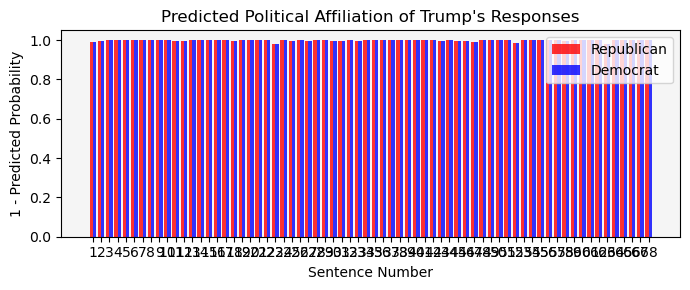

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in trumps_attacks.items() if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 3))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
ax.set_title('Predicted Political Affiliation of Trump\'s Responses')
ax.set_xlabel('Sentence Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(np.arange(1, N + 1))
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()


# Named Entity Recognition


In [169]:
# Print out all sentences in which Trump adresses Harris (including her, she etc.)
# Create list of references
harris_references = ["Harris", "Kamala"]#, "Vice President", " She", " Her "]
trump_harris_sentences = []
for response in trumps_responses:
    sentences = re.split(r'(?<=[.!?]) +', response)
    for sentence in sentences:
        if any(ref.lower() in sentence.lower() for ref in harris_references):
            trump_harris_sentences.append(sentence)

for sentence in trump_harris_sentences:
    print(sentence)

# Number of sentences
print(f"\nNumber of sentences: {len(trump_harris_sentences)}\n")

# Print out all sentences in which Harris adresses Trump (including him, he etc.)
# Create list of references
trump_references = ["Trump", "Donald"]#, "Former President", " He ", " He's", " Him "]
harris_trump_sentences = []
for response in kamalas_responses:
    sentences = re.split(r'(?<=[.!?]) +', response)
    for sentence in sentences:
        if any(ref.lower() in sentence.lower() for ref in trump_references):
            harris_trump_sentences.append(sentence)

for sentence in harris_trump_sentences:
    print(sentence)

# Number of sentences
print(f"\nNumber of sentences: {len(harris_trump_sentences)}")


Number of sentences: 0

My opponent has a plan that I call the Trump sales tax, which would be a 20% tax on everyday goods that you rely on to get through the month.
Economists have said that Trump's sales tax would actually result for middle-class families in about $4,000 more a year because of his policies and his ideas about what should be the backs of middle-class people paying for tax cuts for billionaires.
Let's talk about what Donald Trump left us.
Donald Trump left us the worst unemployment since the Great Depression.
Donald Trump left us the worst public health epidemic in a century.
Donald Trump left us the worst attack on our democracy since the Civil War.
And what we have done is clean up Donald Trump's mess.
So, Donald Trump has no plan for you.
What Goldman Sachs has said is that Donald Trump's plan would make the economy worse.
What the Wharton School has said is Donald Trump's plan would actually explode the deficit.
And I'd invite you to know that Donald Trump actuall

## Sentiment Analysis

In [76]:
# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_lg')
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe('spacytextblob')
text = 'I had a really horrible day. It was the worst day ever! But every now and then I have a really good day that makes me happy.'
doc = nlp(text)
print(doc._.blob.polarity)                            # Polarity: -0.125
print(doc._.blob.subjectivity)                        # Subjectivity: 0.9                        

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch

-0.125
0.9


/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [77]:
def average_sentiment(sentences, nlp):
    sentences = re.split(r'[.!?]', sentences)
    
    if len(sentences) == 1:
        doc = nlp(sentences[0])
        return doc._.blob.polarity, doc._.blob.subjectivity
    
    else:
        polarity = 0
        subjectivity = 0
        for sentence in sentences:
            doc = nlp(sentence)
            polarity += doc._.blob.polarity
            subjectivity += doc._.blob.subjectivity
        return polarity/len(sentences), subjectivity/len(sentences)
    
def sentence_sentiment(responses, nlp):
    all_sentences = []
    all_polarity = []
    all_subjectivitty = []
    for response in responses:
        response = re.split(r'[.!?]', response)
        all_sentences += response
    
    for sentence in all_sentences:
        doc = nlp(sentence)
        all_polarity.append(doc._.blob.polarity)
        all_subjectivitty.append(doc._.blob.subjectivity)

    return all_polarity, all_subjectivitty

In [78]:
trumps_sentiments = [average_sentiment(response, nlp) for response in trumps_responses]
kamalas_sentiments = [average_sentiment(response, nlp) for response in kamalas_responses]

trumps_all_polarity, trumps_all_subjectivity = sentence_sentiment(trumps_responses, nlp)
kamalas_all_polarity, kamalas_all_subjectivity = sentence_sentiment(kamalas_responses, nlp)

In [79]:
# Print some examples of trumps responses with their sentiment scores
for i in range(5):
    print(f"Trump Response {i+1}: {trumps_responses[i]}")
    print(f"Sentiment: {trumps_sentiments[i]}\n")

Trump Response 1: Nice to see you. Have fun.
Sentiment: (0.3, 0.39999999999999997)

Trump Response 2: Thank you.
Sentiment: (0.0, 0.0)

Trump Response 3: First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the 

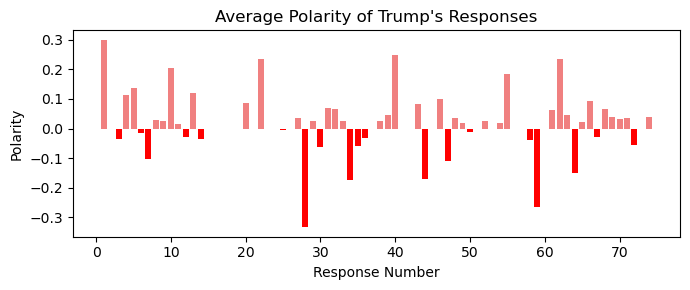

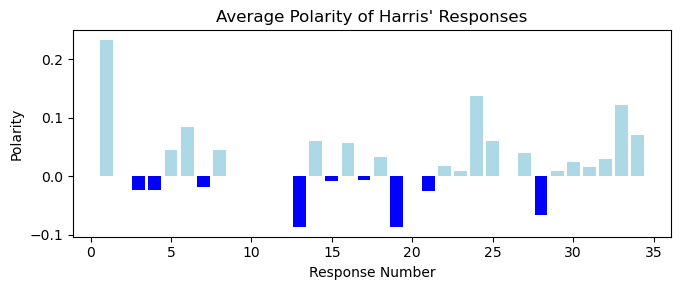

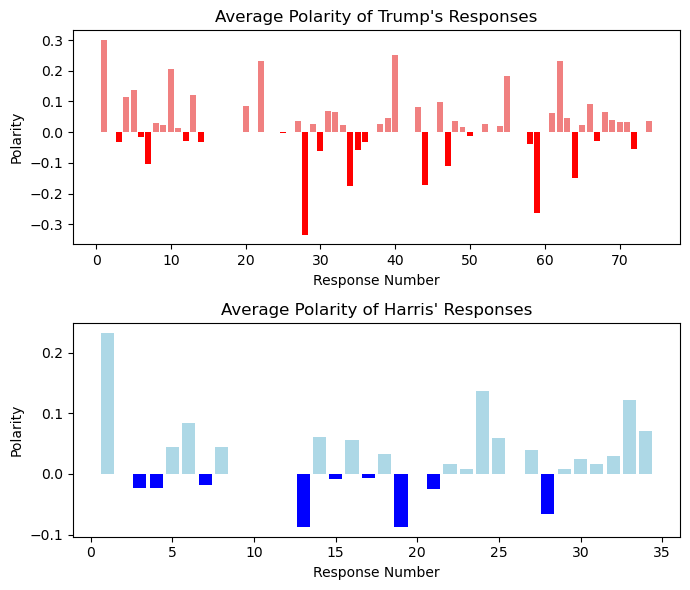

In [80]:
# Plot the polarity of trump's responses using a bar plot
# Negative values indicate negative sentiment, positive values indicate positive sentiment
# Negative bars are colored in a dark red, positive bars are colored in a light red
import numpy as np
import matplotlib.pyplot as plt

N = len(trumps_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in trumps_sentiments]
colors = ['red' if sentiment < 0 else 'lightcoral' for sentiment in y]

fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(x, y, color=colors)
ax.set_title('Average Polarity of Trump\'s Responses')
ax.set_xlabel('Response Number')
ax.set_ylabel('Polarity')
plt.tight_layout()
plt.show()

N = len(kamalas_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in kamalas_sentiments]
colors = ['blue' if sentiment < 0 else 'lightblue' for sentiment in y]

fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(x, y, color=colors)
ax.set_title('Average Polarity of Harris\' Responses')
ax.set_xlabel('Response Number')
ax.set_ylabel('Polarity')
plt.tight_layout()
plt.show()

# Now, plot both trumps and kamalas responses in two subplots of the same figure
# Make sure the colors are consistent with the previous plots

fig, axs = plt.subplots(2, 1, figsize=(7, 6))
N = len(trumps_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in trumps_sentiments]
colors = ['red' if sentiment < 0 else 'lightcoral' for sentiment in y]
axs[0].bar(x, y, color=colors)
axs[0].set_title('Average Polarity of Trump\'s Responses')
axs[0].set_xlabel('Response Number')
axs[0].set_ylabel('Polarity')

N = len(kamalas_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in kamalas_sentiments]
colors = ['blue' if sentiment < 0 else 'lightblue' for sentiment in y]
axs[1].bar(x, y, color=colors)
axs[1].set_title('Average Polarity of Harris\' Responses')
axs[1].set_xlabel('Response Number')
axs[1].set_ylabel('Polarity')
plt.tight_layout()
# store the plot in the figure folder in 300 dpi
plt.savefig('../figures/polarity_subplots.png', dpi=300)
plt.show()



In [81]:
# Print out the three most negative sentences from Trump's responses
# and the three most positive sentences from Kamala's responses
import re

trumps_sentences = []
for response in trumps_responses:
    response = re.split(r'[.!?]', response)
    trumps_sentences += response

trumps_polarity = [nlp(sentence)._.blob.polarity for sentence in trumps_sentences]

trumps_polarity_sorted = sorted(list(zip(trumps_sentences, trumps_polarity)), key=lambda x: x[1])

print("Five most negative sentences from Trump's responses:")
for sentence, polarity in trumps_polarity_sorted[:5]:
    print(f"Sentence: {sentence} (Polarity: {polarity})")

print("\n------------------------------\n")

kamalas_sentences = []
for response in kamalas_responses:
    response = re.split(r'[.!?]', response)
    kamalas_sentences += response

kamalas_polarity = [nlp(sentence)._.blob.polarity for sentence in kamalas_sentences]

kamalas_polarity_sorted = sorted(list(zip(kamalas_sentences, kamalas_polarity)), key=lambda x: x[1])

print("Five most negative sentences from Kamala's responses:")
for sentence, polarity in kamalas_polarity_sorted[:5]:
    print(f"Sentence: {sentence} (Polarity: {polarity})")
    

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


Five most negative sentences from Trump's responses:
Sentence:  Probably the worst in our nation's history (Polarity: -1.0)
Sentence:  They have and she has destroyed our country with policy that's insane (Polarity: -1.0)
Sentence:  They didn't include the worst cities (Polarity: -1.0)
Sentence:  They didn't include the cities with the worst crime (Polarity: -1.0)
Sentence:  She gave all that stuff up, very wrongly, very horribly (Polarity: -1.0)

------------------------------

Five most negative sentences from Kamala's responses:
Sentence:  It's insulting to the women of America (Polarity: -1.0)
Sentence:  Women were horribly raped (Polarity: -1.0)
Sentence:  And on that day, the president of the United States incited a violent mob to attack our nation's Capitol, to desecrate our nation's Capitol (Polarity: -0.8)
Sentence:  Let's remember Charlottesville, where there was a mob of people carrying tiki torches, spewing antisemitic hate, and what did the president then at the time say (

In [82]:
# Print out the three most subjective sentences from Trump's responses
# and the three most subjective sentences from Kamala's responses
# The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective

trumps_subjectivity = [nlp(sentence)._.blob.subjectivity for sentence in trumps_sentences]
trumps_subjectivity_sorted = sorted(list(zip(trumps_sentences, trumps_subjectivity)), key=lambda x: x[1], reverse=True)

print("Five most subjective sentences from Trump's responses:")
for sentence, subjectivity in trumps_subjectivity_sorted[:5]:
    print(f"Sentence: {sentence} (Subjectivity: {subjectivity})")

print("\n------------------------------\n")

kamalas_subjectivity = [nlp(sentence)._.blob.subjectivity for sentence in kamalas_sentences]
kamalas_subjectivity_sorted = sorted(list(zip(kamalas_sentences, kamalas_subjectivity)), key=lambda x: x[1], reverse=True)

print("Five most subjective sentences from Kamala's responses:")

for sentence, subjectivity in kamalas_subjectivity_sorted[:5]:
    print(f"Sentence: {sentence} (Subjectivity: {subjectivity})")

    

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


Five most subjective sentences from Trump's responses:
Sentence: Nice to see you (Subjectivity: 1.0)
Sentence:  Probably the worst in our nation's history (Subjectivity: 1.0)
Sentence:  They're going in violently (Subjectivity: 1.0)
Sentence:  I created one of the greatest economies in the history of our country (Subjectivity: 1.0)
Sentence:  We had the greatest economy (Subjectivity: 1.0)

------------------------------

Five most subjective sentences from Kamala's responses:
Sentence:  Wade as president of the United States, I will proudly sign it into law (Subjectivity: 1.0)
Sentence:  It's insulting to the women of America (Subjectivity: 1.0)
Sentence: Talk about extreme (Subjectivity: 1.0)
Sentence:  So let's talk about what is important in this race (Subjectivity: 1.0)
Sentence: Well let's talk about extreme (Subjectivity: 1.0)


In [83]:
# Print one of Trumps sentences along with the sentiment score for each word.
# The sentiment score is a tuple of (polarity, subjectivity)

sentence = trumps_responses[27]
doc = nlp(sentence)
for token in doc:
    print(f"Word: {token.text}, Sentiment: {token._.blob.sentiment}")



Word: use, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: me, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: ,, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: the, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: FBI, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: --, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: they, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: were, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: defrauding, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: statements, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: ., Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: They, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: did, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: n't, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: include, Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)
Word: the, Sentiment: Sen

In [84]:
# Analyse the statistical difference in the distribution of sentiment between Trump and Harris
# That is, check whether the sentiment of Trump's responses has a different distribution than Harris' responses
# Make sure to test for a difference of the distributions, which accounts for changes over time

from scipy.stats import ks_2samp

# Perform the Kolmogorov-Smirnov test
statistic, p_value = ks_2samp(trumps_all_polarity, kamalas_all_polarity)
print(f"Kolmogorov-Smirnov Test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Perform the Kolmogorov-Smirnov test
statistic, p_value = ks_2samp(trumps_all_subjectivity, kamalas_all_subjectivity)
print(f"Kolmogorov-Smirnov Test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# The kolmorogov-smirnov test is a non-parametric test that compares the distribution of two samples
# The non-parametric test is used because the sentiment scores are not normally distributed 
# which is tested by the Shapiro-Wilk test

print()
from scipy.stats import shapiro

print("Polarity:")

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(trumps_all_polarity)
print(f"Shapiro-Wilk Test for Trump's Polarity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(kamalas_all_polarity)
print(f"Shapiro-Wilk Test for Harris' Polarity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# both p-values are less than 0.05, which means that the null hypothesis that the data is normally distributed is rejected
# the sentiment scores are not normally distributed

print("\nSubjectivity:")

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(trumps_all_subjectivity)
print(f"Shapiro-Wilk Test for Trump's Subjectivity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(kamalas_all_subjectivity)
print(f"Shapiro-Wilk Test for Harris' Subjectivity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")



Kolmogorov-Smirnov Test:
Statistic: 0.10187041306115176
P-value: 0.005992149096793954
Kolmogorov-Smirnov Test:
Statistic: 0.1270227077834575
P-value: 0.0002426568452857982

Polarity:
Shapiro-Wilk Test for Trump's Polarity:
Statistic: 0.7414778586585746
P-value: 2.5837275438017716e-35
Shapiro-Wilk Test for Harris' Polarity:
Statistic: 0.7786741444610967
P-value: 8.956689609247559e-23

Subjectivity:
Shapiro-Wilk Test for Trump's Subjectivity:
Statistic: 0.6887499315190861
P-value: 7.879900785383289e-38
Shapiro-Wilk Test for Harris' Subjectivity:
Statistic: 0.7880413101446664
P-value: 2.454731240310645e-22


In [85]:
# Mann-Whitney U test
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(trumps_all_polarity, kamalas_all_polarity)
print(f"Mann-Whitney U Test for Polarity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(trumps_all_subjectivity, kamalas_all_subjectivity)
print(f"Mann-Whitney U Test for Subjectivity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Print mean and standard deviation of the sentiment scores for Trump and Harris
print("\nMean and Standard Deviation of Polarity:")
print(f"Trump: Mean: {np.mean(trumps_all_polarity)}, Standard Deviation: {np.std(trumps_all_polarity)}")
print(f"Harris: Mean: {np.mean(kamalas_all_polarity)}, Standard Deviation: {np.std(kamalas_all_polarity)}")

print("\nMean and Standard Deviation of Subjectivity:")
print(f"Trump: Mean: {np.mean(trumps_all_subjectivity)}, Standard Deviation: {np.std(trumps_all_subjectivity)}")
print(f"Harris: Mean: {np.mean(kamalas_all_subjectivity)}, Standard Deviation: {np.std(kamalas_all_subjectivity)}")



Mann-Whitney U Test for Polarity:
Statistic: 167768.5
P-value: 0.029030496072278197
Mann-Whitney U Test for Subjectivity:
Statistic: 164762.0
P-value: 0.007728718142776909

Mean and Standard Deviation of Polarity:
Trump: Mean: 0.018975162970477195, Standard Deviation: 0.27475663342615014
Harris: Mean: 0.026564138256057444, Standard Deviation: 0.18743672146907003

Mean and Standard Deviation of Subjectivity:
Trump: Mean: 0.2022172609231595, Standard Deviation: 0.31000521426561095
Harris: Mean: 0.21834822491388148, Standard Deviation: 0.27376044706496694


#### Statistical significant difference for polarity

Trump is more negative than Harris.

#### Statistical significant difference for subjectivity 

Trump is more objective than Harris.

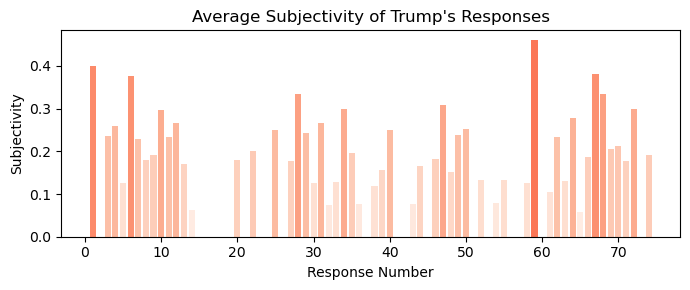

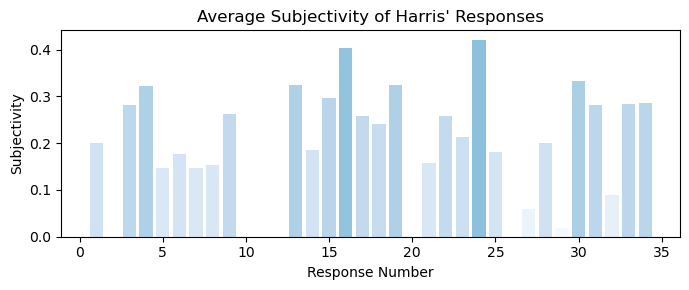

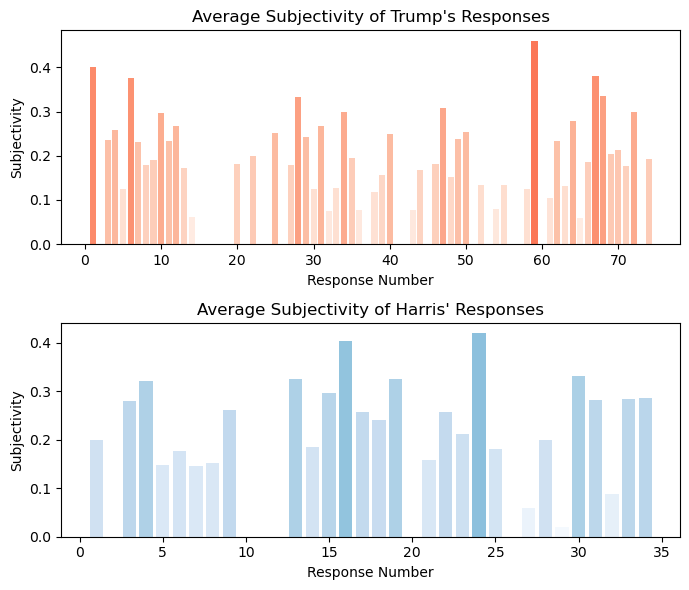

In [86]:
# Plot average subjectivity of trump's responses using a bar plot
# Values closer to 0 are objective, values closer to 1 are subjective
# Bars are continously colored from light red to dark red based on the subjectivity value

N = len(trumps_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[1] for sentiment in trumps_sentiments]
colors = plt.cm.Reds(y)

fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(x, y, color=colors)
ax.set_title('Average Subjectivity of Trump\'s Responses')
ax.set_xlabel('Response Number')
ax.set_ylabel('Subjectivity')
plt.tight_layout()
plt.show()

N = len(kamalas_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[1] for sentiment in kamalas_sentiments]
colors = plt.cm.Blues(y)

fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(x, y, color=colors)
ax.set_title('Average Subjectivity of Harris\' Responses')
ax.set_xlabel('Response Number')
ax.set_ylabel('Subjectivity')
plt.tight_layout()
plt.show()

# Now, plot both trumps and kamalas responses in two subplots of the same figure
# Make sure the colors are consistent with the previous plots

fig, axs = plt.subplots(2, 1, figsize=(7, 6))
N = len(trumps_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[1] for sentiment in trumps_sentiments]
colors = plt.cm.Reds(y)
axs[0].bar(x, y, color=colors)
axs[0].set_title('Average Subjectivity of Trump\'s Responses')
axs[0].set_xlabel('Response Number')
axs[0].set_ylabel('Subjectivity')

N = len(kamalas_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[1] for sentiment in kamalas_sentiments]
colors = plt.cm.Blues(y)
axs[1].bar(x, y, color=colors)
axs[1].set_title('Average Subjectivity of Harris\' Responses')
axs[1].set_xlabel('Response Number')
axs[1].set_ylabel('Subjectivity')

plt.tight_layout()
# store the plot in the figure folder in 300 dpi
plt.savefig('../figures/subjectivity_subplots.png', dpi=300)
plt.show()


In [87]:
# Report the mean and standard deviation of the subjectivity scores 
# based on [sentiment[1] for sentiment in trumps_sentiments] and [sentiment[1] for sentiment in kamalas_sentiments]

print("\nMean and Standard Deviation of Subjectivity:")
#print(f"Trump: Mean: {np.mean([sentiment[1] for sentiment in trumps_sentiments])}, Standard Deviation: {np.std([sentiment[1] for sentiment in trumps_sentiments])}")
#print(f"Harris: Mean: {np.mean([sentiment[1] for sentiment in kamalas_sentiments])}, Standard Deviation: {np.std([sentiment[1] for sentiment in kamalas_sentiments])}")
# avoid: UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U1'), dtype('<U1')) -> None
# by converting the sentiment scores to float
trumps_all_subjectivity = [float(score) for score in trumps_all_subjectivity]
kamalas_all_subjectivity = [float(score) for score in kamalas_all_subjectivity]

print("\nMean and Standard Deviation of Subjectivity:")
print(f"Trump: Mean: {np.mean(trumps_all_subjectivity)}, Standard Deviation: {np.std(trumps_all_subjectivity)}")
print(f"Harris: Mean: {np.mean(kamalas_all_subjectivity)}, Standard Deviation: {np.std(kamalas_all_subjectivity)}")




Mean and Standard Deviation of Subjectivity:

Mean and Standard Deviation of Subjectivity:
Trump: Mean: 0.2022172609231595, Standard Deviation: 0.31000521426561095
Harris: Mean: 0.21834822491388148, Standard Deviation: 0.27376044706496694


In [88]:
# Print Trumps top 3 most subjective responses and top 3 most negative responses
# Print Harris' top 3 most subjective responses and top 3 most negative responses

trumps_subjective_responses = {response: sentiment[1] for response, sentiment in zip(trumps_responses, trumps_sentiments)}
trumps_negative_responses = {response: sentiment[0] for response, sentiment in zip(trumps_responses, trumps_sentiments)}

harris_subjective_responses = {response: sentiment[1] for response, sentiment in zip(kamalas_responses, kamalas_sentiments)}
harris_negative_responses = {response: sentiment[0] for response, sentiment in zip(kamalas_responses, kamalas_sentiments)}

print("Trump's Top 3 Most Subjective Responses:")
for response in sorted(trumps_subjective_responses, key=trumps_subjective_responses.get, reverse=True)[:3]:
    print(f"Subjectivity: {trumps_subjective_responses[response]}")
    print(response)
    print()

print("\nTrump's Top 3 Most Negative Responses:")
for response in sorted(trumps_negative_responses, key=trumps_negative_responses.get)[:3]:
    print(f"Polarity: {trumps_negative_responses[response]}")
    print(response)
    print()

print("\nHarris' Top 3 Most Subjective Responses:")
for response in sorted(harris_subjective_responses, key=harris_subjective_responses.get, reverse=True)[:3]:
    print(f"Subjectivity: {harris_subjective_responses[response]}")
    print(response)
    print()

print("\nHarris' Top 3 Most Negative Responses:")
for response in sorted(harris_negative_responses, key=harris_negative_responses.get)[:3]:
    print(f"Polarity: {harris_negative_responses[response]}")
    print(response)
    print()
    


Trump's Top 3 Most Subjective Responses:
Subjectivity: 0.46049382716049375
And that's the kind of talent we have with her. She's worse than Biden. In my opinion, I think he's the worst president in the history of our country. She goes down as the worst vice president in the history of our country. But let me tell you something. She is a horrible negotiator. They sent her in to negotiate. As soon as they left Putin did the invasion.

Subjectivity: 0.39999999999999997
Nice to see you. Have fun.

Subjectivity: 0.38133928571428566
This is the most divisive presidency in the history of our country. There's never been anything like it. They're destroying our country. And they come up with things like what she just said going back many, many years when a lot of people including Mayor Bloomberg agreed with me on the Central Park Five. They admitted -- they said, they pled guilty. And I said, well, if they pled guilty they badly hurt a person, killed a person ultimately. And if they pled guilty

### Sentiment with SiEBERT Model per response

In [89]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification
import torch
import re
from tqdm import tqdm

gpu_id = 1

# Load the tokenizer and model
with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
    model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english").to(torch.device("cuda:"+str(gpu_id)))

# Function to classify the sentiment of each sentence
def classify_sentiment_sentence(responses):
    sentence_sentiments = {}
    for response in tqdm(responses):
        sentences = re.split(r'[.!?]', response)
        sentiment_scores = []
        for sentence in sentences:
            if sentence == '':
                continue
            else:
                inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
                with torch.no_grad():
                    logits = model(**inputs).logits
                sentiment = torch.argmax(logits, dim=1).item()
                sentiment_scores.append(sentiment)       
        sentence_sentiments[response] = (sum(sentiment_scores) / len(sentiment_scores), np.std(sentiment_scores))
    return sentence_sentiments

# Function to classify the sentiment of each sentence
def classify_sentiment_all_sentences(responses):
    all_sentence_sentiments = []
    for response in tqdm(responses):
        sentences = re.split(r'[.!?]', response)
        sentiment_scores = []
        for sentence in sentences:
            if sentence == '':
                continue
            else:
                print(sentence)
                inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
                with torch.no_grad():
                    logits = model(**inputs).logits
                sentiment = torch.argmax(logits, dim=1).item()
                sentiment_scores.append(sentiment)       
        all_sentence_sentiments.extend(sentiment_scores) 
    return all_sentence_sentiments

def classify_sentiment_response(responses):
    sentence_sentiments = {}
    for response in tqdm(responses):
        inputs = tokenizer(response, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        with torch.no_grad():
            logits = model(**inputs).logits
        sentiment = torch.argmax(logits, dim=1).item()   
        sentence_sentiments[response] = (sentiment, 0)
    return sentence_sentiments

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [90]:
test_responses = [
    "I love this product. It's amazing! Highly recommended.",  # Positive
    "This is the worst experience I've ever had. Completely terrible.",  # Negative
    "The service was okay. Nothing special, but not bad either.",  # Neutral
    "I was impressed by the quality. The customer service was great too.",  # Positive
    "It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.",  # Mixed (partially positive and negative)
    #"Number one, I have nothing to do, as you know and as she knows better than anyone, I have nothing to do with Project 2025. That's out there. I haven't read it. I don't want to read it, purposely. I'm not going to read it. This was a group of people that got together, they came up with some ideas. I guess some good, some bad. But it makes no difference. I have nothing to do -- everybody knows I'm an open book. Everybody knows what I'm going to do. Cut taxes very substantially. And create a great economy like I did before. We had the greatest economy. We got hit with a pandemic. And the pandemic was, not since 1917 where 100 million people died has there been anything like it? We did a phenomenal job with the pandemic. We handed them over a country where the economy and where the stock market was higher than it was before the pandemic came in. Nobody's ever seen anything like it. We made ventilators for the entire world. We got gowns. We got masks. We did things that nobody thought possible. And people give me credit for rebuilding the military. They give me credit for a lot of things. But not enough credit for the great job we did with the pandemic. But the only jobs they got were bounce-back jobs. These were jobs, bounce back. And it bounced back and it went to their benefit. But I was the one that created them. They know it and so does everybody else."
]

# Assuming classify_sentiment function is defined as shown before
test_sentiments = classify_sentiment_sentence(test_responses)

# Print the results to verify
for response, sentiment in test_sentiments.items():
    print(f"Response: '{response}'")
    print(f"Average Sentiment Score: {sentiment}")
    print("-" * 50)

print()
# Assuming classify_sentiment function is defined as shown before
test_sentiments = classify_sentiment_response(test_responses)

# Print the results to verify
for response, sentiment in test_sentiments.items():
    print(f"Response: '{response}'")
    print(f"Average Sentiment Score: {sentiment}")
    print("-" * 50)

100%|██████████| 5/5 [00:00<00:00, 28.95it/s]


Response: 'I love this product. It's amazing! Highly recommended.'
Average Sentiment Score: (1.0, 0.0)
--------------------------------------------------
Response: 'This is the worst experience I've ever had. Completely terrible.'
Average Sentiment Score: (0.0, 0.0)
--------------------------------------------------
Response: 'The service was okay. Nothing special, but not bad either.'
Average Sentiment Score: (0.5, 0.5)
--------------------------------------------------
Response: 'I was impressed by the quality. The customer service was great too.'
Average Sentiment Score: (1.0, 0.0)
--------------------------------------------------
Response: 'It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.'
Average Sentiment Score: (0.3333333333333333, 0.4714045207910317)
--------------------------------------------------



100%|██████████| 5/5 [00:00<00:00, 69.20it/s]

Response: 'I love this product. It's amazing! Highly recommended.'
Average Sentiment Score: (1, 0)
--------------------------------------------------
Response: 'This is the worst experience I've ever had. Completely terrible.'
Average Sentiment Score: (0, 0)
--------------------------------------------------
Response: 'The service was okay. Nothing special, but not bad either.'
Average Sentiment Score: (0, 0)
--------------------------------------------------
Response: 'I was impressed by the quality. The customer service was great too.'
Average Sentiment Score: (1, 0)
--------------------------------------------------
Response: 'It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.'
Average Sentiment Score: (1, 0)
--------------------------------------------------


In [91]:
test_sentiments

{"I love this product. It's amazing! Highly recommended.": (1, 0),
 "This is the worst experience I've ever had. Completely terrible.": (0, 0),
 'The service was okay. Nothing special, but not bad either.': (0, 0),
 'I was impressed by the quality. The customer service was great too.': (1, 0),
 "It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.": (1,
  0)}

In [92]:
# We need the indices of the responses through the entire debate
indexed_responses = {idx: line for idx, line in enumerate(data.split('\n')) if line}

In [93]:
trumps_sentiments = classify_sentiment_sentence(trumps_responses)
harris_sentiments = classify_sentiment_sentence(kamalas_responses)

100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


In [94]:
# Print sentiments of the first 5 responses and sentences
for sentence, sentiment in trumps_sentiments.items():
    print(sentiment, sentence)



(1.0, 0.0) Nice to see you. Have fun.
(1.0, 0.0) Thank you.
(0.35135135135135137, 0.47739247926096473) First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. We were at 21%. But 

In [95]:
# Write a function that increments a value for each negative sentence in a response and 
# increments another value for each positive sentence in a response
# The function should return the number of positive and negative sentences in a response

def count_positive_negative_sentences(responses):
    positive_sentences = []
    negative_sentences = []
    for response in tqdm(responses):
        pos_values = 0
        neg_values = 0
        sentences = re.split(r'[.!?]', response)
        for sentence in sentences:
            if sentence == '':
                continue
            else:
                inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
                with torch.no_grad():
                    logits = model(**inputs).logits
                sentiment = torch.argmax(logits, dim=1).item()
                if sentiment == 0:
                    neg_values += 1
                elif sentiment == 1:
                    pos_values += 1
        positive_sentences.append(pos_values)
        negative_sentences.append(neg_values)
    return positive_sentences, negative_sentences


posT, negT = count_positive_negative_sentences(trumps_responses)
posK, negK = count_positive_negative_sentences(kamalas_responses)

100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


In [96]:
# Find index of the 5 most positive and 5 most negative responses
# Print all 5 responses 

most_positive_idx = np.argsort(posT)[-5:]
most_negative_idx = np.argsort(negT)[-5:]

print("Most Positive Responses:")
for idx in most_positive_idx:
    print(f"Response {idx}: {trumps_responses[idx]}")
    print()

print("\nMost Negative Responses:")
for idx in most_negative_idx:
    print(f"Response {idx}: {trumps_responses[idx]}")
    print()
    

Most Positive Responses:
Response 2: First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. We were at 21%. But that's being generous because many things are 50, 60, 70, and 80% 

In [97]:
# Find index of the 5 most positive and 5 most negative responses
# Print all 5 responses 

most_positive_idx = np.argsort(posK)[-5:]
most_negative_idx = np.argsort(negK)[-5:]

print("Most Positive Responses:")
for idx in most_positive_idx:
    print(f"Response {idx}: {kamalas_responses[idx]}")
    print()

print("\nMost Negative Responses:")
for idx in most_negative_idx:
    print(f"Response {idx}: {kamalas_responses[idx]}")
    print()
    

Most Positive Responses:
Response 22: Well, let's understand how we got here. On Oct. 7, Hamas, a terrorist organization, slaughtered 1,200 Israelis. Many of them young people who were simply attending a concert. Women were horribly raped. And so absolutely, I said then, I say now, Israel has a right to defend itself. We would. And how it does so matters. Because it is also true far too many innocent Palestinians have been killed. Children, mothers. What we know is that this war must end. It must when, end immediately, and the way it will end is we need a cease-fire deal and we need the hostages out. And so we will continue to work around the clock on that. Work around the clock also understanding that we must chart a course for a two-state solution. And in that solution, there must be security for the Israeli people and Israel and in equal measure for the Palestinians. But the one thing I will assure you always, I will always give Israel the ability to defend itself, in particular as 

In [98]:
indexed_sentiments = {}
for idx, response in indexed_responses.items():
    if not response:
        continue
    response = response.split(": ")[1]
    if response in trumps_sentiments:
        indexed_sentiments[idx] = "T", trumps_sentiments[response]
    elif response in harris_sentiments:
        indexed_sentiments[idx] = "H", harris_sentiments[response]


In [99]:
indexed_sentiments

{9: ('H', (1.0, 0.0)),
 10: ('T', (1.0, 0.0)),
 11: ('T', (1.0, 0.0)),
 12: ('T', (1.0, 0.0)),
 16: ('H', (0.7222222222222222, 0.4479032082388083)),
 18: ('T', (0.35135135135135137, 0.47739247926096473)),
 20: ('H', (0.36363636363636365, 0.4810456929208347)),
 22: ('T', (0.6666666666666666, 0.4714045207910316)),
 24: ('H', (0.3333333333333333, 0.4714045207910317)),
 25: ('T', (0.3333333333333333, 0.4714045207910317)),
 27: ('T', (0.125, 0.33071891388307384)),
 29: ('H', (0.5555555555555556, 0.4969039949999533)),
 31: ('T', (0.20833333333333334, 0.4061164310337068)),
 34: ('T', (0.25, 0.4330127018922193)),
 35: ('T', (0.4, 0.4898979485566356)),
 36: ('T', (0.9545454545454546, 0.20829889522526548)),
 38: ('H', (0.38461538461538464, 0.48650425541051995)),
 39: ('H', (0.38461538461538464, 0.48650425541051995)),
 41: ('T', (0.42857142857142855, 0.49487165930539345)),
 43: ('T', (0.15789473684210525, 0.36464227527765836)),
 45: ('T', (0.38461538461538464, 0.48650425541051995)),
 47: ('H', (0

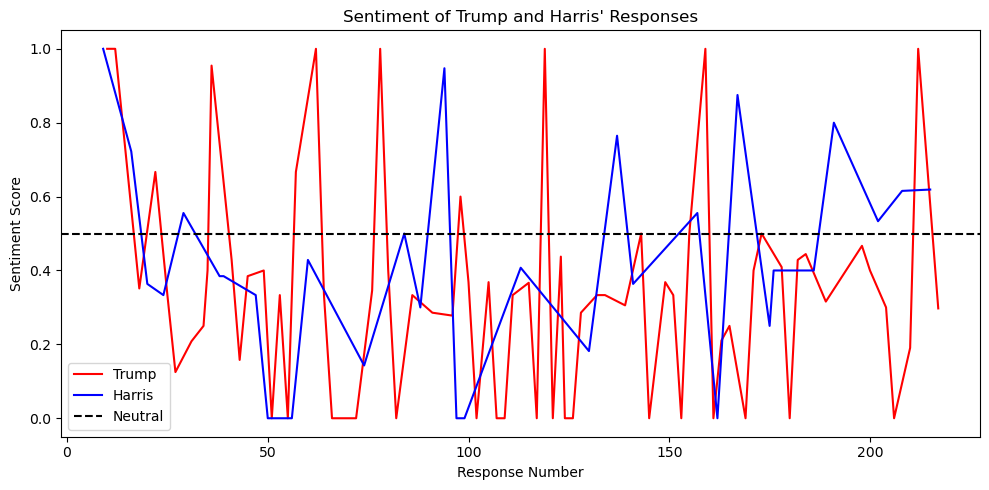

In [100]:
# Plot the indexed sentiments 
# Use a red line for Trump's responses and a blue line for Harris' responses
# Use the indexed sentiments with the idices for the x axis
# The sentiment score will be the y axis
import matplotlib.pyplot as plt

trump_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
trump_sents = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
harris_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]
harris_sents = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_indices, trump_sents, color='red', label="Trump")
ax.plot(harris_indices, harris_sents, color='blue', label="Harris")
# line at 1 for neutral
ax.axhline(.5, color='black', linestyle='--', label='Neutral')
ax.set_title("Sentiment of Trump and Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Sentiment Score")
ax.legend()
plt.tight_layout()
# store the plot in the figure folder in 300 dpi
plt.savefig('../figures/sentiment_plot.png', dpi=300)
plt.show()


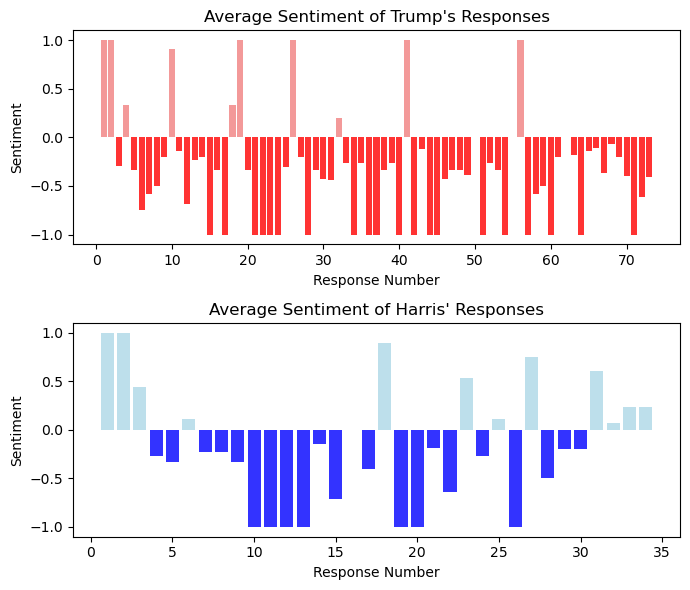

In [101]:
# Plot Trumps and Harris' sentiment scores in two subplots of the same figure
# Do not use the indexed sentiments, but the trumps_sentiments and harris_sentiments dictionaries
# The color of the bars should be consistent with the previous plots
# Valence of the sentiment is indicated by the strength of the color
# Positive sentiment is light, negative sentiment is dark
# The x-axis should be the response number and the y-axis should be the sentiment score

# Adjust the sentiment scores to be between -1 and 1
trumps_sentiments_adj = {idx: (2 * sentiment[0] - 1, sentiment[1]) for idx, sentiment in trumps_sentiments.items()}
harris_sentiments_adj = {idx: (2 * sentiment[0] - 1, sentiment[1]) for idx, sentiment in harris_sentiments.items()}

fig, axs = plt.subplots(2, 1, figsize=(7, 6))
N = len(trumps_sentiments_adj)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in trumps_sentiments_adj.values()]
colors = ['red' if sentiment < 0 else 'lightcoral' for sentiment in y]
axs[0].bar(x, y, color=colors, alpha=.8)
axs[0].set_title('Average Sentiment of Trump\'s Responses')
axs[0].set_xlabel('Response Number')
axs[0].set_ylabel('Sentiment')

N = len(harris_sentiments_adj)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in harris_sentiments_adj.values()]
colors = ['blue' if sentiment < 0 else 'lightblue' for sentiment in y]
axs[1].bar(x, y, color=colors, alpha=.8)
axs[1].set_title('Average Sentiment of Harris\' Responses')
axs[1].set_xlabel('Response Number')
axs[1].set_ylabel('Sentiment')
plt.tight_layout()
# store the plot in the figure folder in 300 dpi
plt.savefig('../figures/sentiment_bars.png', dpi=300)
plt.show()





In [102]:
print(len(trump_sents), len(harris_sents))

75 33


In [103]:
import numpy as np
from scipy import stats

# 1. Check for normality using the Shapiro-Wilk test (optional)
shapiro_test_list_1 = stats.shapiro(trump_sents)
shapiro_test_list_2 = stats.shapiro(harris_sents)

print(f"Shapiro-Wilk Test for List 1: W={shapiro_test_list_1.statistic}, p-value={shapiro_test_list_1.pvalue}")
print(f"Shapiro-Wilk Test for List 2: W={shapiro_test_list_2.statistic}, p-value={shapiro_test_list_2.pvalue}")

# 2. Perform the Kolmogorov-Smirnov test
ks_test = stats.ks_2samp(trump_sents, harris_sents)
print(f"Kolmogorov-Smirnov Test: D-statistic={ks_test.statistic}, p-value={ks_test.pvalue}")


mann_whitney_test = stats.mannwhitneyu(trump_sents, harris_sents, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic={mann_whitney_test.statistic}, p-value={mann_whitney_test.pvalue}")

# Now to the test for the adjusted sentiment scores
adj_trump_sentiments = [sentiment[0] for sentiment in trumps_sentiments_adj.values()]
adj_harris_sentiments = [sentiment[0] for sentiment in harris_sentiments_adj.values()]

# 1. Check for normality using the Shapiro-Wilk test (optional)
shapiro_test_list_1 = stats.shapiro(adj_trump_sentiments)
shapiro_test_list_2 = stats.shapiro(adj_harris_sentiments)

print(f"Shapiro-Wilk Test for List 1: W={shapiro_test_list_1.statistic}, p-value={shapiro_test_list_1.pvalue}")
print(f"Shapiro-Wilk Test for List 2: W={shapiro_test_list_2.statistic}, p-value={shapiro_test_list_2.pvalue}")

# 2. Perform the Kolmogorov-Smirnov test
ks_test = stats.ks_2samp(adj_trump_sentiments, adj_harris_sentiments)
print(f"Kolmogorov-Smirnov Test: D-statistic={ks_test.statistic}, p-value={ks_test.pvalue}")

mann_whitney_test = stats.mannwhitneyu(adj_trump_sentiments, adj_harris_sentiments, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic={mann_whitney_test.statistic}, p-value={mann_whitney_test.pvalue}")

Shapiro-Wilk Test for List 1: W=0.8553861133367127, p-value=4.905271892933419e-07
Shapiro-Wilk Test for List 2: W=0.940336124544622, p-value=0.06947946239540032
Kolmogorov-Smirnov Test: D-statistic=0.19272727272727272, p-value=0.3144519339516555
Mann-Whitney U Test: U-statistic=1051.0, p-value=0.2107748346727213
Shapiro-Wilk Test for List 1: W=0.8584675369105772, p-value=8.218421719134906e-07
Shapiro-Wilk Test for List 2: W=0.9358008538585605, p-value=0.04628219554586931
Kolmogorov-Smirnov Test: D-statistic=0.22038678485092666, p-value=0.17586626799711258
Mann-Whitney U Test: U-statistic=989.0, p-value=0.08954141634865559


In [104]:
# Print the mean and standard deviation of the adjusted sentiment scores
# Use the adjusted sentiment scores to calculate the mean and standard deviation
print("\nMean and Standard Deviation of Adjusted Sentiment Scores:")
print(f"Trump: Mean: {np.mean([sentiment[0] for sentiment in trumps_sentiments_adj.values()])}, Standard Deviation: {np.std([sentiment[0] for sentiment in trumps_sentiments_adj.values()])}")
print(f"Harris: Mean: {np.mean([sentiment[0] for sentiment in harris_sentiments_adj.values()])}, Standard Deviation: {np.std([sentiment[0] for sentiment in harris_sentiments_adj.values()])}")



Mean and Standard Deviation of Adjusted Sentiment Scores:
Trump: Mean: -0.3511364386094019, Standard Deviation: 0.5681486907450783
Harris: Mean: -0.1669413218630119, Standard Deviation: 0.6021954298760739


# Use WordNet to check Specificity

In [105]:
import nltk
from nltk.corpus import wordnet as wn
import string
from nltk.corpus import stopwords

nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def clean_word(word):
    word = word.strip(string.punctuation).lower()
    if '\'' in word:
        word = word.split('\'')[0]
    return word

def get_clean_word_specificity(word):
    word_clean = clean_word(word)
    if word_clean in stop_words:
        return 0
    synsets = wn.synsets(word_clean)
    if not synsets:
        print(f"Word '{word_clean}' not found in WordNet")
        return 0  # Word not found in WordNet
    max_depth = max([synset.max_depth() for synset in synsets])
    #print(clean_word(word), max_depth)
    return max_depth

def get_word_specificity(word):
    synsets = wn.synsets(word)
    if not synsets:
        print(f"Word '{word}' not found in WordNet")
        return 0  # Word not found in WordNet
    max_depth = max([synset.max_depth() for synset in synsets])
    #print(clean_word(word), max_depth)
    return max_depth

def missing_in_wordnet(word):
    synsets = wn.synsets(word)
    if not synsets:
        #print(f"Word '{word}' not found in WordNet")
        return 1  
    else:
        return 0


# Example words
word1 = "dog"
word2 = "animal"

specificity1 = get_word_specificity(word1)
specificity2 = get_word_specificity(word2)

print(f"Specificity of '{word1}': {specificity1}")
print(f"Specificity of '{word2}': {specificity2}")


Specificity of 'dog': 13
Specificity of 'animal': 6


[nltk_data] Downloading package wordnet to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [106]:
# For CLN_kamala_responses and CLN_trump_responses break
# the responses at the \n character to get individual sentences

CLN_kamala_sentences = CLN_kamala_responses.split("\n")
CLN_trump_sentences = CLN_trump_responses.split("\n")



In [107]:
# Assume trumps_responses is a list of sentences
# Ensure trumps_specificity is a dictionary where each response has associated word specificity scores

#trumps_specificity = {response: [get_word_specificity(word) for word in response.split()] for response in trumps_responses}
#harris_specificity = {response: [get_word_specificity(word) for word in response.split()] for response in kamalas_responses}

trumps_specificity = {response: [get_word_specificity(word) for word in response.split()] for response in CLN_trump_sentences}
harris_specificity = {response: [get_word_specificity(word) for word in response.split()] for response in CLN_kamala_sentences}
    

# Function to calculate the average specificity of each response
def calculate_average_specificity(responses):
    return {response: (sum(specificities) / len(specificities)) if specificities else 0 
            for response, specificities in responses.items()}

# Calculate the average specificity for Trump's responses
trumps_avg_specificity = calculate_average_specificity(trumps_specificity)
harris_avg_specificity = calculate_average_specificity(harris_specificity)


Word 'would' not found in WordNet
Word 'everything' not found in WordNet
Word 'Biden' not found in WordNet
Word 'anyone' not found in WordNet
Word 'everybody' not found in WordNet
Word 'everybody' not found in WordNet
Word 'since' not found in WordNet
Word 'anything' not found in WordNet
Word 'anything' not found in WordNet
Word 'everybody' not found in WordNet
Word 'else' not found in WordNet
Word 'Biden' not found in WordNet
Word 'anything' not found in WordNet
Word 'else' not found in WordNet
Word 'everything' not found in WordNet
Word 'MAGA' not found in WordNet
Word 'everybody' not found in WordNet
Word 'something' not found in WordNet
Word 'Ronald' not found in WordNet
Word 'could' not found in WordNet
Word 'would' not found in WordNet
Word 'everybody' not found in WordNet
Word 'everybody' not found in WordNet
Word 'else' not found in WordNet
Word 'something' not found in WordNet
Word 'would' not found in WordNet
Word 'JD' not found in WordNet
Word 'JD' not found in WordNet
Word 

In [108]:
# List all unique words in the CLN_trump_sentences and CLN_kamala_sentences
unique_words_trump = set()
for response in CLN_trump_sentences:
    unique_words_trump.update(response.split())

unique_words_harris = set()
for response in CLN_kamala_sentences:
    unique_words_harris.update(response.split())

# Evaluate how many percentage of the unique words are missing in WordNet
missing_trump = sum([missing_in_wordnet(word) for word in unique_words_trump])
missing_harris = sum([missing_in_wordnet(word) for word in unique_words_harris])

print(f"Percentage of unique words in Trump's responses missing in WordNet: {missing_trump / len(unique_words_trump) * 100:.2f}%")
print(f"Percentage of unique words in Harris' responses missing in WordNet: {missing_harris / len(unique_words_harris) * 100:.2f}%")


Percentage of unique words in Trump's responses missing in WordNet: 5.66%
Percentage of unique words in Harris' responses missing in WordNet: 4.76%


In [109]:
def aggregate_specificity(responses_avg_specificity):
    return sum(responses_avg_specificity.values()) / len(responses_avg_specificity)

# Aggregating specificity scores
trumps_aggregate_specificity = aggregate_specificity(trumps_avg_specificity)
harris_aggregate_specificity = aggregate_specificity(harris_avg_specificity)

print(f"Trump's Aggregate Specificity: {trumps_aggregate_specificity}")
print(f"Harris' Aggregate Specificity: {harris_aggregate_specificity}")


Trump's Aggregate Specificity: 7.098870534052228
Harris' Aggregate Specificity: 6.888268671445486


In [110]:
# List Trump's top 5 responses with the highest average specificity
trumps_top_specificity = sorted(trumps_avg_specificity.items(), key=lambda x: x[1], reverse=True)[:3]
print("Trump's Top 5 Responses with Highest Average Specificity:")
for response, avg_specificity in trumps_top_specificity:
    print(f"Response: '{response}'")
    print(f"Average Specificity: {avg_specificity}")
    print("-" * 50)

print("-" * 50)

# List Harris' top 5 responses with the highest average specificity
harris_top_specificity = sorted(harris_avg_specificity.items(), key=lambda x: x[1], reverse=True)[:3]
print("Harris' Top 5 Responses with Highest Average Specificity:")
for response, avg_specificity in harris_top_specificity:
    print(f"Response: '{response}'")
    print(f"Average Specificity: {avg_specificity}")
    print("-" * 50)

Trump's Top 5 Responses with Highest Average Specificity:
Response: 'David one thing'
Average Specificity: 10.666666666666666
--------------------------------------------------
Response: 'throw campaign like dog even know president president'
Average Specificity: 10.0
--------------------------------------------------
Response: 'find'
Average Specificity: 9.0
--------------------------------------------------
--------------------------------------------------
Harris' Top 5 Responses with Highest Average Specificity:
Response: 'lie lie audible'
Average Specificity: 10.666666666666666
--------------------------------------------------
Response: 'get get president time invite Taliban Camp David place storied significance Americans place honor importance american diplomacy invite receive respected world leader former president president invite Camp David appreciate role responsibility President United States commander chief level respect get back point consistently disparage demean member 

In [111]:
# List Trump's top 5 responses with the lowest average specificity
trumps_top_specificity = sorted(trumps_avg_specificity.items(), key=lambda x: x[1], reverse=False)[:3]
print("Trump's Top 5 Responses with Lowest Average Specificity:")
for response, avg_specificity in trumps_top_specificity:
    print(f"Response: '{response}'")
    print(f"Average Specificity: {avg_specificity}")
    print("-" * 50)

print("-" * 50)

# List Harris' top 5 responses with the lowest average specificity
harris_top_specificity = sorted(harris_avg_specificity.items(), key=lambda x: x[1], reverse=False)[:3]
print("Harris' Top 5 Responses with Lowest Average Specificity:")
for response, avg_specificity in harris_top_specificity:
    print(f"Response: '{response}'")
    print(f"Average Specificity: {avg_specificity}")
    print("-" * 50)

Trump's Top 5 Responses with Lowest Average Specificity:
Response: ''
Average Specificity: 0
--------------------------------------------------
Response: 'respond'
Average Specificity: 2.0
--------------------------------------------------
Response: 'know alive'
Average Specificity: 3.5
--------------------------------------------------
--------------------------------------------------
Harris' Top 5 Responses with Lowest Average Specificity:
Response: 'inaudible'
Average Specificity: 0.0
--------------------------------------------------
Response: ''
Average Specificity: 0
--------------------------------------------------
Response: 'true'
Average Specificity: 6.0
--------------------------------------------------


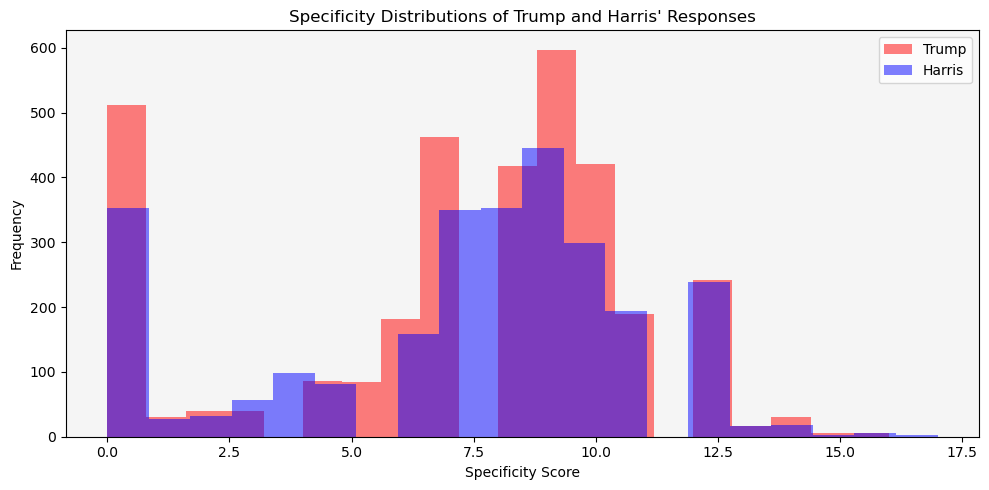

In [112]:
import matplotlib.pyplot as plt

# Plot distributions of specificity scores for each word in Trump's responses and Harris' responses
# Put both into one plot with different colors for each distribution (trump in red, harris in blue)


# Function to plot the specificity distributions
def plot_specificity_distributions(trumps_specificity, harris_specificity):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(trumps_specificity, bins=20, color='red', alpha=0.5, label="Trump")
    ax.hist(harris_specificity, bins=20, color='blue', alpha=0.5, label="Harris")
    ax.set_title("Specificity Distributions of Trump and Harris' Responses")
    ax.set_xlabel("Specificity Score")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.set_facecolor('whitesmoke')
    plt.tight_layout()
    plt.show()

# Extract the specificity scores for each word in Trump's responses and Harris' responses
trumps_specificity_scores = [score for response in trumps_specificity.values() for score in response]
harris_specificity_scores = [score for response in harris_specificity.values() for score in response]

# Plot the distributions
plot_specificity_distributions(trumps_specificity_scores, harris_specificity_scores)



In [113]:
from scipy.stats import ttest_ind

# Perform t-test to compare means
t_stat, p_value = ttest_ind(list(trumps_avg_specificity.values()), 
                            list(harris_avg_specificity.values()))
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 0.6077063422118184, P-value: 0.5446820228336348


# Using Bolognesi Data to check Specificity

In [114]:
# Loading Bolognesi from data/Bolognesi_Data.csv
# without pandas
with open('../data/Bolognesi_Data.csv', 'r') as file:
    bolognesi_data = file.read()
    
# Split the data into lines
bolognesi_lines = bolognesi_data.split('\n')


In [115]:
# Turn the data into a dictionary
# Drop the header
# Store the first column as the key and the other columns as list of values 
# for this list, we only store the first and the last column
bolognesi_dict = {}
for line in bolognesi_lines[1:]:
    if not line:
        continue
    columns = line.split(',')
    bolognesi_dict[columns[0]] = [float(columns[1]), float(columns[-1])]

# Print the first 5 entries in the dictionary
for key, value in list(bolognesi_dict.items())[:5]:
    print(f"{key}: {value}")

entirety: [3.07, 1.8571428571428572]
creationism: [1.69, 2.0]
thousand: [3.08, 2.0]
flashback: [2.36, 2.428571428571429]
organist: [4.0, 2.571428571428571]


In [116]:
CLN_trump_all_responses = CLN_trump_responses.replace("\n", " ")
CLN_kamala_all_responses = CLN_kamala_responses.replace("\n", " ")

# Check how many of the words in all trump and kamala responses are in the Bolognesi dictionary
trump_words = set(CLN_trump_all_responses.split())
kamala_words = set(CLN_kamala_all_responses.split())

trump_bolognesi_words = trump_words.intersection(bolognesi_dict.keys())
kamala_bolognesi_words = kamala_words.intersection(bolognesi_dict.keys())

print(f"Number of words in Trump's responses found in Bolognesi dictionary: {len(trump_bolognesi_words)}")
print(f"Number of words in Kamala's responses found in Bolognesi dictionary: {len(kamala_bolognesi_words)}")

# Print number of unique words in Trump's responses
print(f"Number of unique words in Trump's responses: {len(trump_words)}")
# Print number of unique words in Kamala's responses
print(f"Number of unique words in Kamala's responses: {len(kamala_words)}")

Number of words in Trump's responses found in Bolognesi dictionary: 293
Number of words in Kamala's responses found in Bolognesi dictionary: 379
Number of unique words in Trump's responses: 866
Number of unique words in Kamala's responses: 924


In [117]:
# Load nltk pos tagger
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Now check how many of the words in all trump and kamala responses are NOUNS
trump_nouns = set()
kamala_nouns = set()

for word in trump_words:
    tokens = nltk.word_tokenize(word)  # Tokenize the word
    pos = nltk.pos_tag(tokens)[0][1]   # Tag the first (and only) token
    if pos.startswith('N'):            # Check if it's a noun
        trump_nouns.add(word)

for word in kamala_words:
    tokens = nltk.word_tokenize(word)  # Tokenize the word
    pos = nltk.pos_tag(tokens)[0][1]   # Tag the first (and only) token
    if pos.startswith('N'):            # Check if it's a noun
        kamala_nouns.add(word)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [118]:
# Check how many nouns of trump and harris responses are in the Bolognesi dictionary
trump_nouns_bolognesi = trump_nouns.intersection(bolognesi_dict.keys())
kamala_nouns_bolognesi = kamala_nouns.intersection(bolognesi_dict.keys())

# Express this in percentage
trump_nouns_bolognesi_percentage = len(trump_nouns_bolognesi) / len(trump_nouns) * 100
kamala_nouns_bolognesi_percentage = len(kamala_nouns_bolognesi) / len(kamala_nouns) * 100

print(f"Percentage of nouns in Trump's responses found in Bolognesi dictionary: {trump_nouns_bolognesi_percentage:.2f}%")
print(f"Percentage of nouns in Kamala's responses found in Bolognesi dictionary: {kamala_nouns_bolognesi_percentage:.2f}%")

Percentage of nouns in Trump's responses found in Bolognesi dictionary: 45.87%
Percentage of nouns in Kamala's responses found in Bolognesi dictionary: 52.49%


In [119]:
# The second value in the Bolognesi dictionary is the specificity score
# Calculate the average specificity of nouns in Trump's responses
trump_nouns_specificity = [bolognesi_dict[word][1] for word in trump_nouns_bolognesi]
trump_nouns_avg_specificity = sum(trump_nouns_specificity) / len(trump_nouns_specificity)

# Calculate the average specificity of nouns in Kamala's responses
kamala_nouns_specificity = [bolognesi_dict[word][1] for word in kamala_nouns_bolognesi]
kamala_nouns_avg_specificity = sum(kamala_nouns_specificity) / len(kamala_nouns_specificity)

print(f"Average Specificity of nouns in Trump's responses based on Bolognesi data: {round(trump_nouns_avg_specificity,3)}")
print(f"Average Specificity of nouns in Kamala's responses based on Bolognesi data: {round(kamala_nouns_avg_specificity,3)}")

Average Specificity of nouns in Trump's responses based on Bolognesi data: 2.063
Average Specificity of nouns in Kamala's responses based on Bolognesi data: 2.034


In [120]:
# The first value in the Bolognesi dictionary is the concreteness score
# Calculate the average concreteness of nouns in Trump's responses
trump_nouns_concreteness = [bolognesi_dict[word][0] for word in trump_nouns_bolognesi]
trump_nouns_avg_concreteness = sum(trump_nouns_concreteness) / len(trump_nouns_concreteness)

# Calculate the average concreteness of nouns in Kamala's responses
kamala_nouns_concreteness = [bolognesi_dict[word][0] for word in kamala_nouns_bolognesi]
kamala_nouns_avg_concreteness = sum(kamala_nouns_concreteness) / len(kamala_nouns_concreteness)

print(f"Average Concreteness of nouns in Trump's responses based on Bolognesi data: {round(trump_nouns_avg_concreteness,3)}")
print(f"Average Concreteness of nouns in Kamala's responses based on Bolognesi data: {round(kamala_nouns_avg_concreteness,3)}")


Average Concreteness of nouns in Trump's responses based on Bolognesi data: 3.534
Average Concreteness of nouns in Kamala's responses based on Bolognesi data: 3.317


In [121]:
# Plot CLN_trump_all_responses with the specificity and concreteness of nouns

# First, get rid off all words in CLN_trump_all_responses that are not in the Bolognesi dictionary
clean_trump_bolognesi_responses = []
clean_harris_bolognesi_responses = []

for response in CLN_trump_responses.split("\n"):
    temp = []
    for word in response.split(" "):
        if word in bolognesi_dict:
            temp.append(word)
    if temp:
        clean_trump_bolognesi_responses.append(temp)

for response in CLN_kamala_responses.split("\n"):
    temp = []
    for word in response.split(" "):
        if word in bolognesi_dict:
            temp.append(word)
    if temp:
        clean_harris_bolognesi_responses.append(temp)
    
clean_trump_bolognesi_responses[:2]

[['fun'],
 ['sale',
  'tax',
  'statement',
  'tariff',
  'country',
  'country',
  'year',
  'world',
  'tariff',
  'case',
  'billion',
  'billion',
  'dollar',
  'fact',
  'tariff',
  'money',
  'billion',
  'dollar',
  'place',
  'tariff',
  'tariff',
  'inflation',
  'economy',
  'inflation',
  'country',
  'buster',
  'country',
  'inflation',
  'people',
  'nation',
  'history',
  'thing',
  'year',
  'disaster',
  'people',
  'middle',
  'class',
  'class',
  'top',
  'million',
  'people',
  'country',
  'prison',
  'jail',
  'institution',
  'asylum',
  'job',
  'union',
  'union',
  'town',
  'town',
  'building',
  'people',
  'country',
  'country',
  'level',
  'criminality',
  'economy',
  'history',
  'country']]

In [122]:
# How many responses are left?
print(f"Number of Trump responses left after cleaning: {len(clean_trump_bolognesi_responses)}")
print(f"Number of Harris responses left after cleaning: {len(clean_harris_bolognesi_responses)}")
# How many before?
print(f"Number of Trump responses before cleaning: {len(CLN_trump_responses.split())}")
print(f"Number of Harris responses before cleaning: {len(CLN_kamala_responses.split())}")


Number of Trump responses left after cleaning: 65
Number of Harris responses left after cleaning: 28
Number of Trump responses before cleaning: 3361
Number of Harris responses before cleaning: 2735


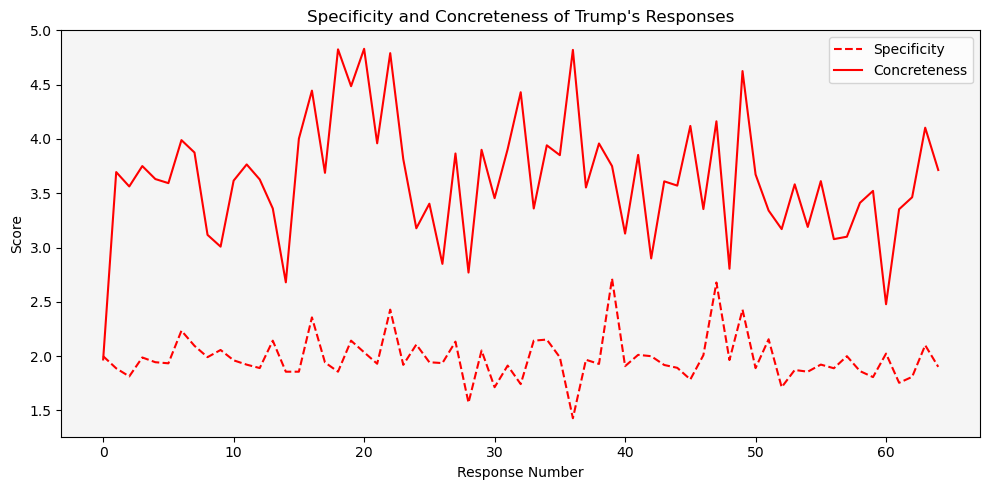

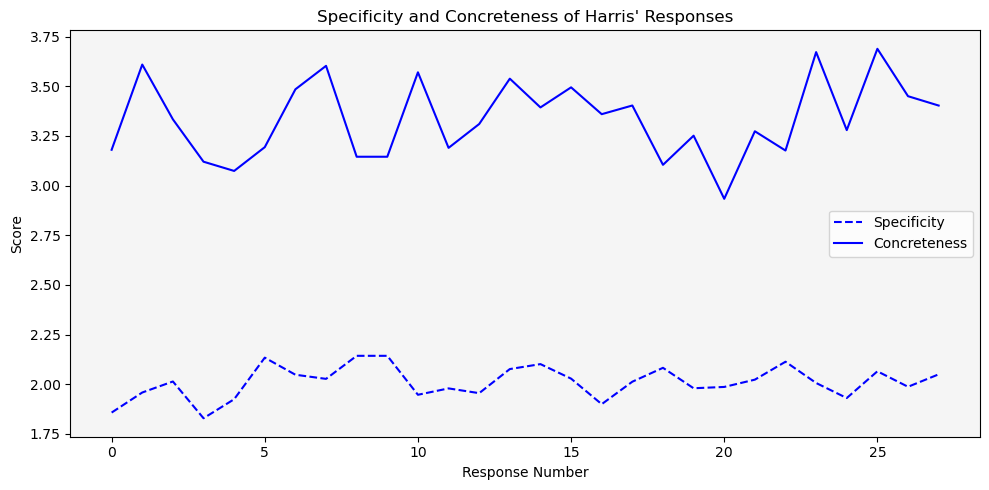

In [123]:
# For each response, calculate the average specificity and concreteness
trump_avg_specificity = []
trump_avg_concreteness = []
harris_avg_specificity = []
harris_avg_concreteness = []

for response in clean_trump_bolognesi_responses:
    specificity = [bolognesi_dict[word][1] for word in response]
    concreteness = [bolognesi_dict[word][0] for word in response]
    trump_avg_specificity.append(sum(specificity) / len(specificity))
    trump_avg_concreteness.append(sum(concreteness) / len(concreteness))

for response in clean_harris_bolognesi_responses:
    specificity = [bolognesi_dict[word][1] for word in response]
    concreteness = [bolognesi_dict[word][0] for word in response]
    harris_avg_specificity.append(sum(specificity) / len(specificity))
    harris_avg_concreteness.append(sum(concreteness) / len(concreteness))

# Plot both the average specificity and concreteness over the responses
# a dotted line for specificity and a solid line for concreteness
# a red line for Trump and a blue line for Harris
# one plot for each candidate

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_avg_specificity, color='red', linestyle='--', label="Specificity")
ax.plot(trump_avg_concreteness, color='red', label="Concreteness")
ax.set_title("Specificity and Concreteness of Trump's Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(harris_avg_specificity, color='blue', linestyle='--', label="Specificity")
ax.plot(harris_avg_concreteness, color='blue', label="Concreteness")
ax.set_title("Specificity and Concreteness of Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()




### Aligning both responses via index

In [124]:
import spacy
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')


trump_indexed_concreteness = {}
trump_indexed_specificity = {}
harris_indexed_concreteness = {}
harris_indexed_specificity = {}

for idx, response in indexed_responses.items():
    if not response:
        continue
    if response.startswith("FORMER PRESIDENT DONALD TRUMP: "):
        response = response.split(": ")[1]
        
        # Cleaning
        response = response.replace('.', '').replace(',', '').replace('--', '').replace('\'re', '').replace('\'m', '')
        doc = nlp(response)
        response_cleaned = ' '.join([token.lemma_ for token in doc if token.is_alpha])
        response_cleaned = ' '.join([word for word in response_cleaned.split() if word.lower() not in stop_words])
        
        # add the concreteness score for each word in the response up
        concreteness = 0
        specificity = 0
        for word in response_cleaned.split():
            if word in bolognesi_dict:
                concreteness += bolognesi_dict[word][0]
                specificity += bolognesi_dict[word][1]
        # add average concreteness score for the response
        trump_indexed_concreteness[idx] = concreteness / len(response_cleaned.split())
        trump_indexed_specificity[idx] = specificity / len(response_cleaned.split())

    elif response.startswith("VICE PRESIDENT KAMALA HARRIS: "):
        response = response.split(": ")[1]
        
        # Cleaning
        response = response.replace('.', '').replace(',', '').replace('--', '').replace('\'re', '').replace('\'m', '')
        doc = nlp(response)
        response_cleaned = ' '.join([token.lemma_ for token in doc if token.is_alpha])
        response_cleaned = ' '.join([word for word in response_cleaned.split() if word.lower() not in stop_words])
        
        # add the concreteness score for each word in the response up
        concreteness = 0
        specificity = 0
        for word in response_cleaned.split():
            if word in bolognesi_dict:
                concreteness += bolognesi_dict[word][0]
                specificity += bolognesi_dict[word][1]
        # add average concreteness score for the response
        harris_indexed_concreteness[idx] = concreteness / len(response_cleaned.split())
        harris_indexed_specificity[idx] = specificity / len(response_cleaned.split())
        
        

[nltk_data] Downloading package stopwords to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


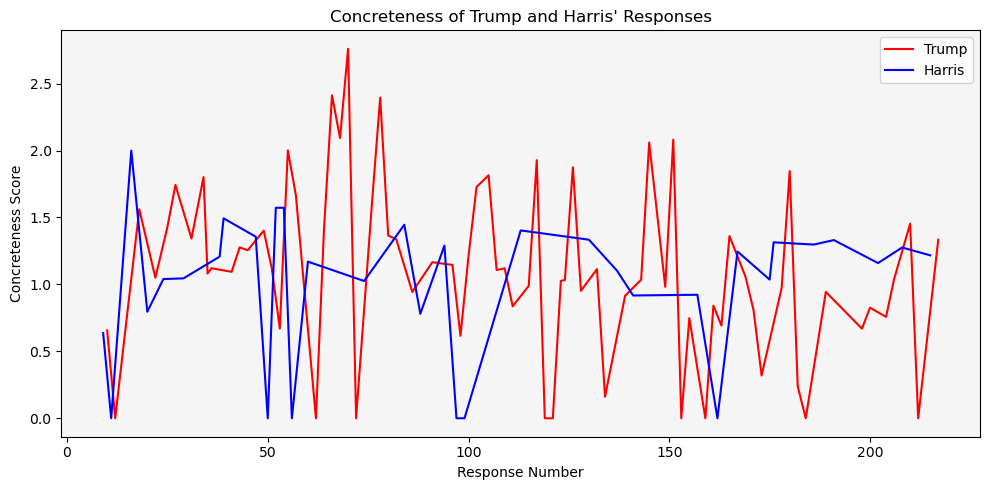

In [125]:
# Plot the concreteness scores for Trump and Harris for each response in the debate
# Do it in one plot with a red line for Trump and a blue line for Harris
# Use the indexed concreteness scores with the idices for the x axis
# The concreteness score will be the y axis

trump_indices = [idx for idx, concreteness in trump_indexed_concreteness.items()]
trump_concreteness = [concreteness for idx, concreteness in trump_indexed_concreteness.items()]
harris_indices = [idx for idx, concreteness in harris_indexed_concreteness.items()]
harris_concreteness = [concreteness for idx, concreteness in harris_indexed_concreteness.items()]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_indices, trump_concreteness, color='red', label="Trump")
ax.plot(harris_indices, harris_concreteness, color='blue', label="Harris")
ax.set_title("Concreteness of Trump and Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Concreteness Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()


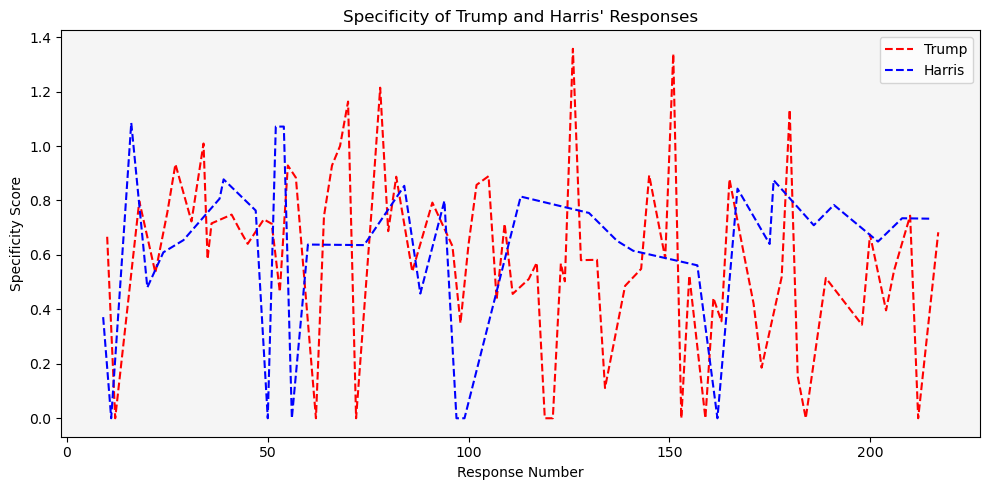

In [126]:
# Plot the concreteness scores for Trump and Harris for each response in the debate
# Do it in one plot with a red line for Trump and a blue line for Harris
# Use the indexed concreteness scores with the idices for the x axis
# The concreteness score will be the y axis

trump_indices = [idx for idx, specificity in trump_indexed_specificity.items()]
trump_specificity = [specificity for idx, specificity in trump_indexed_specificity.items()]
harris_indices = [idx for idx, specificity in harris_indexed_specificity.items()]
harris_specificity = [specificity for idx, specificity in harris_indexed_specificity.items()]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_indices, trump_specificity, color='red', linestyle='--', label="Trump")
ax.plot(harris_indices, harris_specificity, color='blue', linestyle='--', label="Harris")
ax.set_title("Specificity of Trump and Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Specificity Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()

In [127]:
# Print some of the responses with the highest and lowest concreteness scores
# For both candidates to see if the concreteness score makes sense
trump_highest_concreteness = sorted(trump_indexed_concreteness.items(), key=lambda x: x[1], reverse=True)[:3]
trump_lowest_concreteness = sorted(trump_indexed_concreteness.items(), key=lambda x: x[1], reverse=False)[:3]
harris_highest_concreteness = sorted(harris_indexed_concreteness.items(), key=lambda x: x[1], reverse=True)[:3]
harris_lowest_concreteness = sorted(harris_indexed_concreteness.items(), key=lambda x: x[1], reverse=False)[:3]

print("Trump's Responses with Highest Concreteness:")
for idx, concreteness in trump_highest_concreteness:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Concreteness: {concreteness}")
    print("-" * 50)
print("-" * 50)

print("Trump's Responses with Lowest Concreteness:")
for idx, concreteness in trump_lowest_concreteness:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Concreteness: {concreteness}")
    print("-" * 50)
print("-" * 50)
print("Harris' Responses with Highest Concreteness:")
for idx, concreteness in harris_highest_concreteness:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Concreteness: {concreteness}")
    print("-" * 50)
print("-" * 50)
print("Harris' Responses with Lowest Concreteness:")
for idx, concreteness in harris_lowest_concreteness:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Concreteness: {concreteness}")
    print("-" * 50)
print("-" * 50)

Trump's Responses with Highest Concreteness:
Response 70: FORMER PRESIDENT DONALD TRUMP: But the people on television say their dog was eaten by the people that went there.
Concreteness: 2.7600000000000002
--------------------------------------------------
Response 66: FORMER PRESIDENT DONALD TRUMP: Well, I've seen people on television
Concreteness: 2.4125
--------------------------------------------------
Response 78: FORMER PRESIDENT DONALD TRUMP: With local police.
Concreteness: 2.395
--------------------------------------------------
--------------------------------------------------
Trump's Responses with Lowest Concreteness:
Response 12: FORMER PRESIDENT DONALD TRUMP: Thank you.
Concreteness: 0.0
--------------------------------------------------
Response 62: FORMER PRESIDENT DONALD TRUMP: Well, I would like to respond.
Concreteness: 0.0
--------------------------------------------------
Response 72: FORMER PRESIDENT DONALD TRUMP: We'll find out
Concreteness: 0.0
----------------

In [128]:
# Print some of the responses with the highest and lowest specificity scores
# For both candidates to see if the specificity score makes sense
trump_highest_specificity = sorted(trump_indexed_specificity.items(), key=lambda x: x[1], reverse=True)[:3]
trump_lowest_specificity = sorted(trump_indexed_specificity.items(), key=lambda x: x[1], reverse=False)[:3]
harris_highest_specificity = sorted(harris_indexed_specificity.items(), key=lambda x: x[1], reverse=True)[:3]
harris_lowest_specificity = sorted(harris_indexed_specificity.items(), key=lambda x: x[1], reverse=False)[:3]

print("Trump's Responses with Highest Specificity:")
for idx, specificity in trump_highest_specificity:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Specificity: {specificity}")
    print("-" * 50)
print("-" * 50)

print("Trump's Responses with Lowest Specificity:")
for idx, specificity in trump_lowest_specificity:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Specificity: {specificity}")
    print("-" * 50)
print("-" * 50)
print("Harris' Responses with Highest Specificity:")
for idx, specificity in harris_highest_specificity:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Specificity: {specificity}")
    print("-" * 50)
print("-" * 50)
print("Harris' Responses with Lowest Specificity:")
for idx, specificity in harris_lowest_specificity:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Specificity: {specificity}")
    print("-" * 50)
print("-" * 50)




Trump's Responses with Highest Specificity:
Response 126: FORMER PRESIDENT DONALD TRUMP: No judge looked at it.
Specificity: 1.3571428571428572
--------------------------------------------------
Response 151: FORMER PRESIDENT DONALD TRUMP: They threw him out of a campaign like a dog. We don't even know, is he our president? But we have a president...
Specificity: 1.3392857142857144
--------------------------------------------------
Response 78: FORMER PRESIDENT DONALD TRUMP: With local police.
Specificity: 1.2142857142857144
--------------------------------------------------
--------------------------------------------------
Trump's Responses with Lowest Specificity:
Response 12: FORMER PRESIDENT DONALD TRUMP: Thank you.
Specificity: 0.0
--------------------------------------------------
Response 62: FORMER PRESIDENT DONALD TRUMP: Well, I would like to respond.
Specificity: 0.0
--------------------------------------------------
Response 72: FORMER PRESIDENT DONALD TRUMP: We'll find out